In [37]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path
from itertools import product as prod
from scipy.optimize import curve_fit
from scipy.linalg import expm
from scipy.integrate import quad
from colorsys import hls_to_rgb
import pickle, os, sys
import scipy.optimize
from scipy.interpolate import interp1d
from scipy.linalg import expm

sys.path.append("../common")
sys.path.insert(0, "../pyMMF")

from functions import (
    stack_correlation,
    fidelity,
    get_disk_mask,
    colorize,
    logplotTM,
    get_color_map,
    generate_color_shades,
    load_complex32,
)

import pyMMF

In [38]:
# check that we are using the local version of pyMMF
print(f"pyMMF file: {pyMMF.__file__}")

pyMMF file: ../pyMMF/pyMMF/__init__.py


## Prerequesites

Set `FIBER` to:
- `Draka_GRIN` for the [Prysmina BendBright™ OM4 fiber](https://www.prysmiangroup.com/en/bendbright-tm-om4),
- `TL_GRIN_1`, for a segment of the [Tholabs OM2 GIF50C fiber](https://www.thorlabs.de/thorProduct.cfm?partNumber=GIF50C)
- `TL_GRIN_2` or `TL_GRIN_3` for two segment of the same [Tholabs OM2 GIF50C fiber](https://www.thorlabs.de/thorProduct.cfm?partNumber=GIF50C)

In [39]:
# FIBER = 'Draka_GRIN'
FIBER = "TL_GRIN"
DATA_PATH = Path("../Data") / FIBER

# path to save images
IMAGE_FOLDER = Path("../images") / FIBER
os.makedirs(IMAGE_FOLDER, exist_ok=True)


def file_path(file_name):
    return DATA_PATH / file_name


def image_path(file_name):
    return IMAGE_FOLDER / file_name

**Parameters for plots**

In [40]:
REF_SIZE = 24
TICK_SIZE = REF_SIZE
LEGEND_SIZE = REF_SIZE - 4
LABEL_SIZE = REF_SIZE + 2
TITLE_SIZE = REF_SIZE + 2
SMALL_TITLE_SIZE = REF_SIZE
TINY_TITLE_SIZE = REF_SIZE - 4
SUP_TITLE_SIZE = REF_SIZE + 6
FIGSIZE = (8, 5)
SAVE_FIG = True

In [41]:
def get_rotation_matrix(m, l, alpha):
    return np.diag(np.exp(1j * np.array(m) * alpha))


def sort(A):
    return A[ml_sorted_idx, :][:, ml_sorted_idx]


def leq(A, l_val):
    ind = select_l(l_val)
    return A[ind, :][:, ind]


def leq1(A):
    return leq(A, 1)


def meq0(A):
    return A[meq0_sorted_idx, :][:, meq0_sorted_idx]


def ipr_m(A):
    # I = np.abs(A)**2
    # return np.sum(I*deltaM)**2/np.sum(I**2)
    dm_max = int(np.max(deltaM))
    I_dm = []
    for dm in range(dm_max + 1):
        mask = deltaM == dm
        I_dm.append(np.sum(mask * np.abs(A) ** 2) / np.sum(mask))
    I_dm = np.array(I_dm)
    return np.sum(I_dm**2) / np.sum(I_dm) ** 2


def corr(A, B):
    A = A - np.mean(A)
    B = B - np.mean(B)
    return np.sum(A * B.conjugate()) / np.sqrt(
        np.sum(A * A.conjugate()) * np.sum(B * B.conjugate())
    )

In [42]:
data2save = {}


def save_data():
    pickle.dump(data2save, open(DATA_PATH / "processed_data.pkl", "wb"))

# I. Simulation of the fiber modes

## A. Simulation parameters 
(to match the experimental fiber)

In [43]:
NA = 0.2
radius = 25  # in microns
areaSize = (
    2.4 * radius
)  # calculate the field on an area larger than the diameter of the fiber
npoints = 2**8  # resolution of the window
n1 = 1.45
wl = 1.55  # wavelength in microns
curvature = None
k0 = 2.0 * np.pi / wl


r_max = 3.2 * radius
npoints_search = 2**8
dh = 2 * radius / npoints_search

## B. Find modes of straight fiber

### B.1 Create the fiber index profile

In [44]:
profile = pyMMF.IndexProfile(npoints=npoints, areaSize=areaSize)
profile.initParabolicGRIN(n1=n1, a=radius, NA=NA)

### B.2 Instantiate the solver

In [45]:
solver = pyMMF.propagationModeSolver()
solver.setIndexProfile(profile)
solver.setWL(wl)

2023-08-31 15:58:00,028 - pyMMF.core [DEBUG  ]  Debug mode ON.


### B.3 Run the solver

In [46]:
modes = solver.solve(
    mode="radial_test",
    curvature=None,
    r_max=r_max,  # max radius to calculate (and first try for large radial boundary condition)
    dh=dh,  # radial resolution during the computation
    min_radius_bc=0.5,  # min large radial boundary condition
    change_bc_radius_step=0.85,  # change of the large radial boundary condition if fails
    N_beta_coarse=int(1e3),  # number of steps of the initial coarse scan
    degenerate_mode="exp",
    save_func=True,
)

nmodes = modes.number

2023-08-31 15:58:00,175 - pyMMF.solv [INFO   ]  Found 5 radial mode(s) for m=0
2023-08-31 15:58:00,176 - pyMMF.solv [INFO   ]  Searching propagation constant for |l| = 1
2023-08-31 15:58:00,195 - pyMMF.solv [ERROR  ]  Field limit 1.0 at the founded beta=0.05066217542815342 is greater than field_limit_tol=0.001
2023-08-31 15:58:00,235 - pyMMF.solv [WARNING]  Boundary condition could not be met.
2023-08-31 15:58:00,267 - pyMMF.solv [WARNING]  Retrying by changing r_max to 2.72a
2023-08-31 15:58:00,320 - pyMMF.solv [ERROR  ]  Field limit 1.0 at the founded beta=0.05066217542815342 is greater than field_limit_tol=0.001
2023-08-31 15:58:00,360 - pyMMF.solv [WARNING]  Boundary condition could not be met.
2023-08-31 15:58:00,385 - pyMMF.solv [WARNING]  Retrying by changing r_max to 2.31a
2023-08-31 15:58:00,403 - pyMMF.solv [ERROR  ]  Field limit 0.7012700255083901 at the founded beta=0.05066217542815342 is greater than field_limit_tol=0.001
2023-08-31 15:58:00,419 - pyMMF.solv [WARNING]  Bou

### B.4 Retrieve the modes

In [47]:
M = modes.getModeMatrix()
l = modes.l
m = modes.m
ml = list(zip(m, l))
TM_mode = modes.getPropagationMatrix(distance=100)

In [48]:
data2save["modes"] = {
    "m": m,
    "l": l,
    "ml": ml,
    "betas": modes.betas,
    "M": M,
}

save_data()

In [49]:
np.savez(
    file_path("modes.npz"),
    l=l,
    m=m,
    modes_out=M,
    betas=modes.betas,
)

In [50]:
ml_indexed = [[i, x] for i, x in enumerate(ml)]
ml_indexed_sorted = sorted(ml_indexed, key=lambda x: x[1][0])
# ind = np.argsort(np.array(ml), axis = 0)
ml_sorted_idx = [x[0] for x in ml_indexed_sorted]


# ml_sorted_idx
def select_l(l_val):
    return [x[0] for x in ml_indexed_sorted if x[1][1] == l_val]


leq1_sorted_idx = select_l(1)
meq0_sorted_idx = [x[0] for x in ml_indexed_sorted if x[1][0] == 0]

In [51]:
# matrix containing the difference of m (OAM) number between pairs of modes
deltaM = np.zeros((nmodes, nmodes), dtype=float)
for i_val1, m_val1 in enumerate(m):
    for i_val2, m_val2 in enumerate(m):
        deltaM[i_val1, i_val2] = m_val1 - m_val2

# matrix containing the difference of propagation constants beta between pairs of modes
deltaBeta = np.zeros((nmodes, nmodes), dtype=float)
for i_val1, beta_val1 in enumerate(modes.betas):
    for i_val2, beta_val2 in enumerate(modes.betas):
        deltaBeta[i_val1, i_val2] = beta_val1 - beta_val2

# matrix containing the difference of l (radial momentum) number beta between pairs of modes
deltaL = np.zeros((nmodes, nmodes), dtype=float)
for i_val1, l_val1 in enumerate(l):
    for i_val2, l_val2 in enumerate(l):
        deltaL[i_val1, i_val2] = l_val1 - l_val2


def get_mask_l(l_val=None):
    mask = np.zeros((nmodes, nmodes), dtype=int)
    assert l_val is not None or m_val is not None
    for i_val1, (m_val1, l_val1) in enumerate(ml):
        for i_val2, (m_val2, l_val2) in enumerate(ml):
            if l_val1 == l_val and l_val2 == l_val:
                mask[i_val1, i_val2] = 1
    return mask

# II. Experimental data

## A. Load data

### A.1. Load parameters of the fiber and the experiment

In [52]:
with open(file_path("param.pkl"), "rb") as file:
    param = pickle.load(file, encoding="latin1")


# number of pixels in each axis in the input plane (DMD)
N_in = param["fiber"]["inpoints"]
# number of pixels in each axis in the output plane (camera)
N_out = param["fiber"]["onpoints"]

# angles of rotation of the input wavefronts
angles = param["RME"]["angles"]
n_a = param["RME"]["n_angles"]
# number of random input wavefronts
n_rnd = param["RME"]["n_rnd"]
nv_max = param["RME"]["nv_max"]

# number of operatoirs
n_op = param["RME"]["n_op"]
# number of the first modes of each operator sent to the DMD
n_rm = param["RME"]["n_rm"]
n_angles_for_corr = param["RME"]["n_ang_corr"]


# load parameters associated with the shrinked data files
with open(file_path("param_small.pkl"), "rb") as file:
    param = pickle.load(file, encoding="latin1")

# number of deformation values stored in the demo
# (the actual full dataset has 30 deformation values)
n_defomr = param["n_deform"]

# deformation indices used in the demo
deformation_indices = param["deformation_indices"]
# deformation_indices = [0,3]

# deformation values
Delta_x = param["Delta_x"]

In [53]:
with open(file_path("param.pkl"), "rb") as file:
    param = pickle.load(file, encoding="latin1")

param["fiber"]

{'NA': 0.2,
 'radius': 25,
 'name': 'GIF50C',
 'type': 'GRIN',
 'wl': 1.55,
 'n1': 1.46,
 'curvature': None,
 'length': 2500000.0,
 'ipitch': 2.232,
 'opitch': 1.2480000000000002,
 'inpoints': 30,
 'onpoints': 49}

### A.2 Load the measured output fields corresponding to rotated inputs for different deformations 

**load and concatenate the measurements for random input at different levels of deformation**

In [55]:
filepaths = glob.glob(str(file_path("Ys_rnd_small_p1_*.npz")))
arrays = []
for filepath in filepaths:
    data = np.load(filepath)
    arr = load_complex32(filename=filepath)
    arrays.append(arr)
Ys_rnd_p1 = np.stack(arrays, axis=0)
# move the axis so that the penultimate one corresponds to angles
Ys_rnd_p1 = np.moveaxis(Ys_rnd_p1, -3, -2)

filepaths = glob.glob(str(file_path("Ys_rnd_small_p2_*.npz")))
arrays = []
for filepath in filepaths:
    data = np.load(filepath)
    arr = load_complex32(filename=filepath)
    arrays.append(arr)
Ys_rnd_p2 = np.stack(arrays, axis=0)
# move the axis so that the penultimate one corresponds to angles
Ys_rnd_p2 = np.moveaxis(Ys_rnd_p2, -3, -2)

**Concatenate the two polarizations to have the full output fields**

In [56]:
Ys_rnd = np.concatenate((Ys_rnd_p1, Ys_rnd_p2), axis=-1)

### A.3 Load the TMs in the mode basis

In [57]:
TMs_mode = np.load(os.path.join(DATA_PATH, "TMs_mode.npy")).astype(np.complex64)
n_modes = TMs_mode.shape[-1]
# select one polarization, and take only the deformation values used in the demo
TMs = TMs_mode[deformation_indices, :n_modes, :]

In [58]:
# Min_corr = data['modes_in_corr']
# Min = data['modes_in']

## B. Experimentally measured RME correlation

### B.1 Average output intensity for random inputs wavefronts

We excite from one circular polarization and measure both at the output

Text(0.5, 0.98, 'Average intensity')

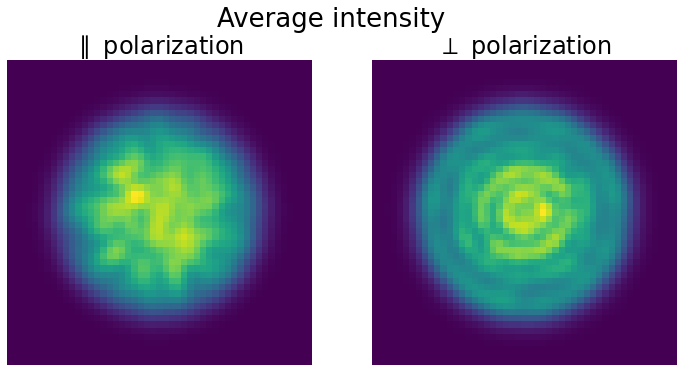

In [59]:
mask_corr = get_disk_mask([N_out, N_out], 0.74 * N_out / 2)
mask_corr_2p = np.concatenate((mask_corr, mask_corr), axis=0)
I_mean = np.mean(np.abs(Ys_rnd[0]) ** 2, axis=(0, 1)).reshape((N_out * 2, N_out))
I_mean_p1 = I_mean[:N_out, :]
I_mean_p2 = I_mean[N_out:, :]
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(I_mean_p1)
plt.axis("off")
plt.title(r"$\parallel$ polarization", fontsize=SMALL_TITLE_SIZE)
plt.subplot(122)
plt.imshow(I_mean_p2)
plt.axis("off")
plt.title(r"$\perp$ polarization", fontsize=SMALL_TITLE_SIZE)
plt.suptitle("Average intensity", fontsize=TITLE_SIZE)

## B.2 Field correlation

In [60]:
# field correlation
Ys_rnd_ref_p1 = Ys_rnd_p1[..., 0, :]
rnd_corr_p1 = stack_correlation(Ys_rnd_p1, Ys_rnd_ref_p1)

Ys_rnd_ref_p2 = Ys_rnd_p2[..., 0, :]
rnd_corr_p2 = stack_correlation(Ys_rnd_p2, Ys_rnd_ref_p2)
# intensity correlation
rndint_corr_p1 = stack_correlation(np.abs(Ys_rnd_p1) ** 2, np.abs(Ys_rnd_ref_p1) ** 2)

#### Compute RME field correlations for both output polarizations

In [61]:
Corr_mean_exp = np.mean(np.abs(rnd_corr_p1), axis=-2)
Corr_std_exp = np.std(np.abs(rnd_corr_p1), axis=-2)

Corr_mean_exp_p2 = np.mean(np.abs(rnd_corr_p2), axis=-2)
Corr_std_exp_p2 = np.std(np.abs(rnd_corr_p2), axis=-2)

data2save["exp"] = {
    "Corr_mean": Corr_mean_exp,
    "Corr_std": Corr_std_exp,
    "angles": angles,
}
save_data()

#### Show the results

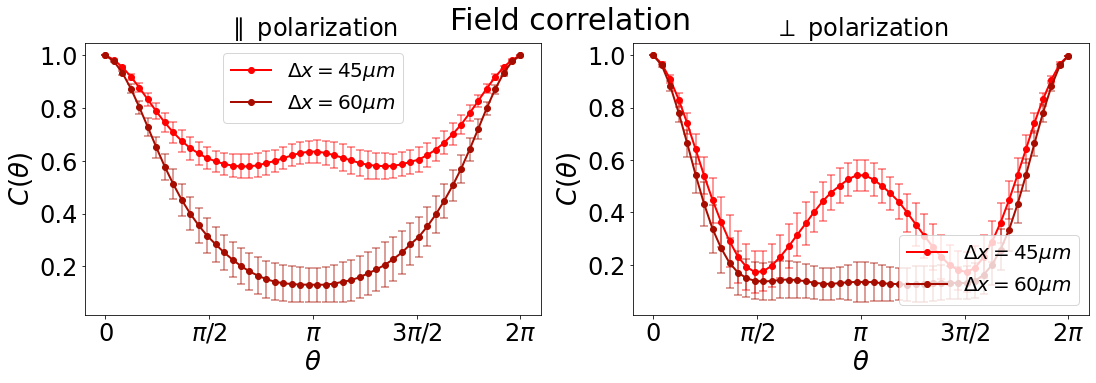

In [62]:
def plot_error(y, y_err, color):
    plt.errorbar(
        angles,
        y,
        yerr=y_err,
        color=color,
        linewidth=2,
        linestyle="None",
        capsize=4,
        capthick=2,
        alpha=0.4,
    )


def show_RME_corr_2pola(show_error=True, save_fig=True):
    deformations2show = [2, 3]
    # colors = generate_color_shades('PuRd', 4)
    cmap = get_color_map(n=len(deformations2show) + 1)
    plt.figure(figsize=(18, 5))
    plt.subplot(121)
    for ind_color, ind_deformation in enumerate(deformations2show):
        color = cmap(ind_color)
        plt.errorbar(
            angles,
            Corr_mean_exp[ind_deformation],
            label=rf"$\Delta x = {Delta_x[ind_deformation]:.0f} \mu m$",
            color=color,
            marker="o",
            linewidth=2,
        )
        if show_error:
            plot_error(
                Corr_mean_exp[ind_deformation],
                Corr_std_exp[ind_deformation],
                color=color,
            )
    plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
    plt.ylabel(r"$C(\theta)$", fontsize=LABEL_SIZE)
    xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
    xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
    plt.xticks(xticks, xtics_labels, fontsize=TICK_SIZE)
    plt.yticks(fontsize=TICK_SIZE)
    plt.legend(fontsize=LEGEND_SIZE)
    plt.title(r"$\parallel$ polarization", fontsize=SMALL_TITLE_SIZE)

    plt.subplot(122)
    for ind_color, ind_deformation in enumerate(deformations2show):
        color = cmap(ind_color)
        plt.errorbar(
            angles,
            Corr_mean_exp_p2[ind_deformation],
            label=rf"$\Delta x = {Delta_x[ind_deformation]:.0f} \mu m$",
            color=color,
            marker="o",
            linewidth=2,
        )
        if show_error:
            plot_error(
                Corr_mean_exp_p2[ind_deformation],
                Corr_std_exp_p2[ind_deformation],
                color=color,
            )
    plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
    plt.ylabel(r"$C(\theta)$", fontsize=LABEL_SIZE)
    xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
    xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
    plt.xticks(xticks, xtics_labels, fontsize=TICK_SIZE)
    plt.yticks(fontsize=TICK_SIZE)
    plt.legend(fontsize=LEGEND_SIZE, loc="lower right")
    plt.title(r"$\perp$ polarization", fontsize=SMALL_TITLE_SIZE)

    plt.suptitle("Field correlation", fontsize=SUP_TITLE_SIZE)

    if save_fig:
        plt.savefig(
            image_path(f"RMEcorr_Vs_deform.svg"),
            dpi=300,
        )


show_RME_corr_2pola(show_error=True, save_fig=SAVE_FIG)

In [63]:
nmodes = TMs_mode.shape[-1]
TMs_pola1 = TMs_mode[:, :nmodes, :]
TMs_pola2 = TMs_mode[:, nmodes:, :]

# III. Theoretical predictions and fit

## A. Equations


$$
    C(\theta) =  1+
        A\sum_q \Gamma_q^2 (\cos(q\theta)-1) B_{\gamma\alpha}(q)
$$

with 
$$
    A = (k_0 l_z)^2 \frac{L}{l_z}
$$

and

$$
    B_{\gamma\alpha} = \sum_{\alpha,\gamma/\left|m_\gamma-m_\alpha\right|=q} \text{sinc}^2\left(\frac{\beta_\gamma-\beta_\alpha}{2}\right) I_{\gamma\alpha}
$$

$$
I_{\gamma\alpha} = \frac{1}{N_{modes}} 
    \int_0^a dr \left|a_\gamma(r)\right|^2 \left|a_\alpha(r)\right|^2 r^2
    \sigma^2_g(r) d_\text{layer}
$$

$$
    \sigma^2_g(r)
    \approx 4 \left(\frac{\Delta n r}{a^2}\right)^2 d_\text{layer}^2
$$

for a radial disorder of the form


$$
    f_p(r) = \frac{d n}{d r} d_\text{layer} b(r)
$$

with $b(r)$ a Gaussian noise so that 

$$
\left\langle b(r) b(r+r') \right\rangle  \approx d_\text{layer} \delta(r')
$$


## B. Parameters

In [64]:
# total fiber length
L_tot = 2.45e4  # in microns
# correlation length in the z direction 100 umn
dz = 1e2  # in microns
# thickness of the deposition layers, also corresponds to the radial correlation length of the discorder
d_layer = 1  # in microns

## C. Computation of the mode dependent terms

In [67]:
def radial_norm(t, r_vec, d):
    return np.sqrt(2 * np.pi * np.sum(np.abs(t) ** 2 * r_vec) * d)


def get_norm_func_radial(f, dh, r_max):
    r_vec = np.arange(0, r_max, d)
    t = f(r_vec)
    return radial_norm(t, r_vec, d)


def normalize_r(t, r_vec, d):
    return t / radial_norm(t, r_vec, d)


def normalize_fr(f):
    return lambda x: f(x) / np.linalg.norm(f(profile.R))


sinc = lambda x: np.sinc(x / np.pi)


# discretization of the radial coordinate
dr = 1e-2
r_max = modes.data[0]["r_max"]
r_vec = np.arange(0, r_max, dr)

# difference of refractive index between the axis (maximum value) and the cladding (minimum value)
Dn = NA**2 / (2.0 * n1)


noise_std = lambda r: -2 * r / (radius**2) * Dn * d_layer * (r > 0) * (r < radius)


# radial profiles of the modes
M = np.array([data["radial_func"](r_vec) for data in modes.data])

# normalization of the radial profile
M = M.transpose() / np.sqrt(
    np.sum(np.abs(M) ** 2 * r_vec * dr, axis=1)
)  # np.linalg.norm(M*r_vec, axis = 1)
M = M.transpose()

MsqR = M**2 * r_vec * noise_std(r_vec)

# I = MsqR@MsqR.transpose()*R0*dr
I = MsqR @ MsqR.transpose() * d_layer * dr  # *dr#/np.sqrt(d_layer)
# beta dependence
mask_beta = sinc(deltaBeta / 2 * dz) ** 2

# coefficient A
coeff = L_tot / dz * (k0 * dz) ** 2 * 1 / nmodes * 0.25

# q values to consider in the azimuthal series decomposition
qs = (1, 2, 3, 4)

## D. RME correlation computation function

In [71]:
eps = np.finfo(float).eps
mask_beta_sqrt = sinc(deltaBeta / 2 * dz)
mask_beta_cos = np.cos(deltaBeta / 2 * dz)
mask_beta_over = (np.abs(deltaBeta) > 0) * (1 / (deltaBeta**2 + eps))
Nz = L_tot / dz
c2 = Nz * 1 / 8 * k0**4 * 1 / nmodes
A1 = (Nz - 1) / 2 * dz**4 * np.einsum("ab,cb->abc", mask_beta_sqrt, mask_beta_sqrt)
Itot = np.einsum("abc,ab,cb->abc", A1, I, I)


def Compute_correlation(gammas, qs):
    C1 = None
    for q, gamma in zip(qs, gammas):
        mask_M = np.abs(deltaM) == q
        A = np.sum(mask_beta * mask_M * I) or 0.0
        cq = gamma**2 * np.cos(q * angles) * A
        C1 = cq if C1 is None else C1 + cq

    C = 1 + coeff * C1
    C = C / C[0]

    return C

## E. Fit the experimenta results with the theoretical model

### C.1 Error function 
Computes the quadratic error between two correlation curves 

In [74]:
def Correlation_error(gammas, qs, Cref):
    # C = Compute_correlation(gammas, qs)
    C = Compute_correlation(gammas, qs)
    error = np.mean(np.abs(Cref - C) ** 2)
    return error


err = lambda x: Correlation_error(x, qs, Cref=Corr_mean_exp[0])

### C.2 Fit the experimental data for different deformations

In [75]:
gammas = []
for ind_deform, Cref in enumerate(Corr_mean_exp):
    err = lambda x: Correlation_error(x, qs, Cref=Cref)
    initial_guess = gammas[-1] if ind_deform > 0 and gammas else [0.1] * len(qs)
    xopt = scipy.optimize.fmin(func=err, x0=initial_guess)
    gammas.append(np.abs(np.array(xopt)))

gammas = np.stack(gammas, axis=0)
n_coeffs_fit = gammas

Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 183
         Function evaluations: 312
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 84
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 174
         Function evaluations: 292
Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 138
         Function evaluations: 233


In [76]:
Corr_theory = np.stack(
    [Compute_correlation(gammas, qs) for gammas in n_coeffs_fit], axis=0
)

data2save["theo"] = {
    "Corr_mean": Corr_theory,
    "gammas": n_coeffs_fit,
    "qs": qs,
}

save_data()

### C.3 Estimation of the importance of each parameter on $C(\theta)$
To quantify the effect of each paramter, we compare the correlation function with the each paramter se to 0 independently.

We observe that for no added deformation, changing the value of $\Gamma_q$ for odd values of $q$ does not change the shape the correlation function. 

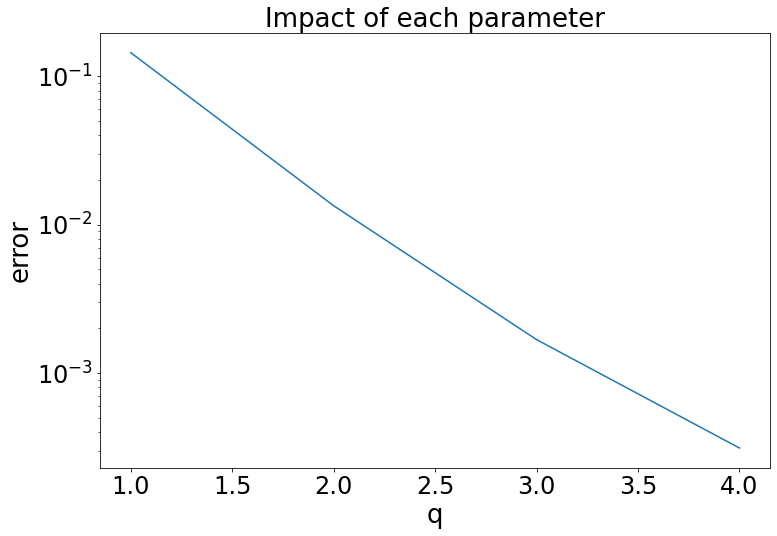

In [95]:
ind_deformation = -1
errors = []

for ind_q, _ in enumerate(n_coeffs_fit[ind_deformation]):
    gammas = np.copy(n_coeffs_fit[ind_deformation])
    C1 = Compute_correlation(gammas, qs)
    gammas[ind_q] = 0
    C2 = Compute_correlation(gammas, qs)
    errors.append(np.mean(np.abs(C1 - C2) ** 2))

plt.figure(figsize=(12, 8))
plt.semilogy(qs, errors)
plt.title("RME error on $C$ compared to each parameter set to 0")
plt.xlabel("q", fontsize=LABEL_SIZE)
plt.xticks(fontsize=TICK_SIZE)
plt.ylabel("error", fontsize=LABEL_SIZE)
plt.title("Impact of each parameter", fontsize=TITLE_SIZE)
plt.yticks(fontsize=TICK_SIZE)

## DShow the results

### D.1 RME Correlation

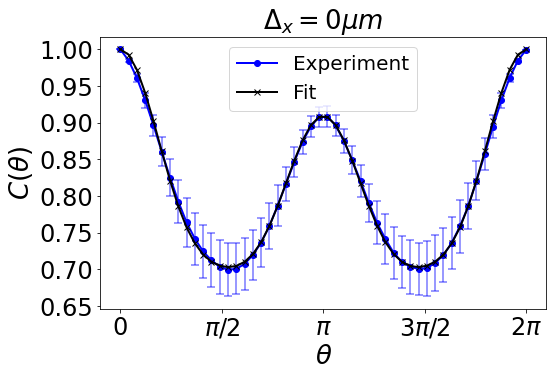

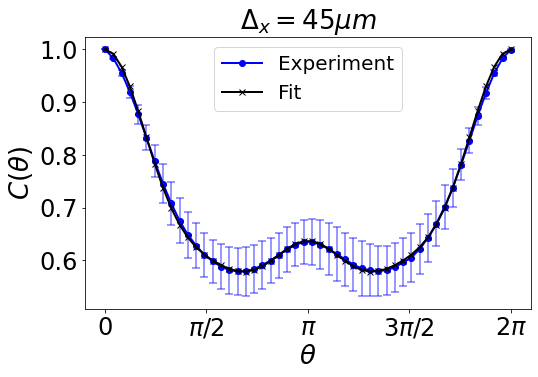

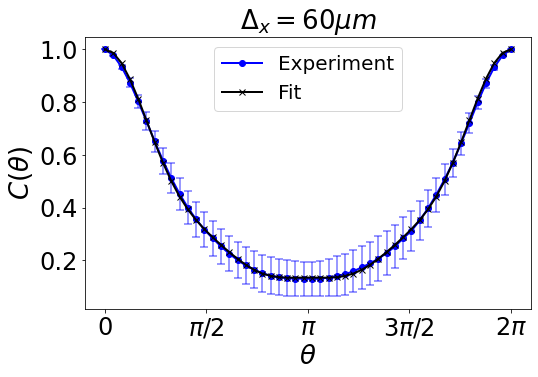

In [78]:
def show_RME_corr(show_error=True, save_fig=True):
    deformations2show = [0, 2, 3]

    for ind_deformation in deformations2show:
        plt.figure(figsize=(8, 5))
        plt.errorbar(
            angles,
            Corr_mean_exp[ind_deformation],
            label=rf"Experiment",
            color="blue",
            marker="o",
            linewidth=2,
        )
        if show_error:
            plot_error(
                Corr_mean_exp[ind_deformation],
                Corr_std_exp[ind_deformation],
                color="blue",
            )

        plt.errorbar(
            angles,
            Corr_theory[ind_deformation],
            label=rf"Fit",
            color="black",
            marker="x",
            linewidth=2,
        )

        plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
        plt.ylabel(r"$C(\theta)$", fontsize=LABEL_SIZE)
        xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
        xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
        plt.xticks(xticks, xtics_labels, fontsize=TICK_SIZE)
        plt.yticks(fontsize=TICK_SIZE)
        plt.legend(fontsize=LEGEND_SIZE)
        plt.title(
            rf"$\Delta_x={Delta_x[ind_deformation]:.0f}\mu m$", fontsize=TITLE_SIZE
        )

    if save_fig:
        plt.savefig(
            image_path(f"RME_exp_Vs_theory.svg"),
            dpi=300,
        )


show_RME_corr(show_error=True, save_fig=SAVE_FIG)

### D.2 Evolution of the fit parameters
Only show significant paramters

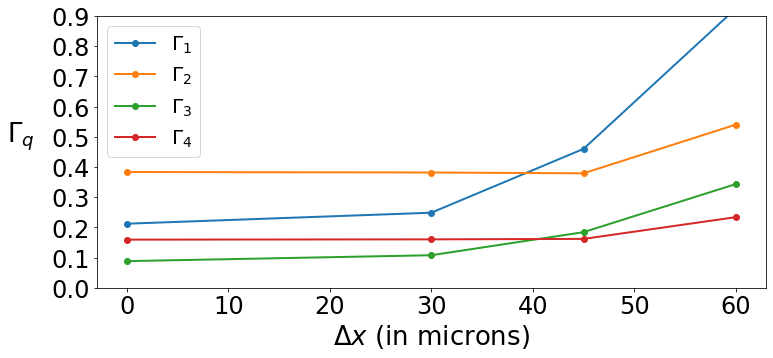

In [80]:
plt.figure(figsize=(12, 5))
for ind_q, q in enumerate(qs):
    plt.plot(
        Delta_x,
        n_coeffs_fit[:, ind_q],
        marker="o",
        label=rf"$\Gamma_{q}$",
        linewidth=2,
    )
plt.legend()
plt.ylabel(r"$\Gamma_q$", fontsize=LABEL_SIZE, labelpad=30, rotation=0)
plt.xlabel(r"$\Delta x$ (in microns)", fontsize=LABEL_SIZE)
plt.xticks(fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)
plt.legend(fontsize=LEGEND_SIZE, loc="upper left")
plt.ylim([0.0, 0.9])

if SAVE_FIG:
    plt.savefig(
        image_path(f"Gamma_q.svg"),
        dpi=300,
    )
# plt.ylim([0,10])

#### Decomposition in the different contributions

# IV. Simulations
**Compare segment model to experiment for no bending**

## A. General parameters

In [ ]:
# number of different realizations of the disorder
n_ave = 5  # in microns
# number of random input wavefront for each realization
n_rnd_input = 100  # in microns

## B. Simulation functions

Note that we add randomness to the segment size to mitigate coherent beating effects

We also add a random phase to the contributions $cos(q\theta)$ using `phi0`

In [81]:
# number of point in the mesh for the radial coordinate
n_r = 2**9
# number of point in the mesh for the angular coordinate
n_th = 2**5

r_max = modes.data[0]["r_max"]

R, TH = np.meshgrid(
    np.linspace(0, r_max, n_r), np.linspace(0, 2 * np.pi, n_th, endpoint=False)
)

dR = areaSize / (2 * (n_r - 1))
dTH = 2 * np.pi / n_th

Mrth = np.array(
    [
        modes.data[i]["radial_func"](R.ravel()) * np.exp(1j * m[i] * TH.ravel())
        for i in range(nmodes)
    ]
).transpose()


## Normalize the radial profiles
norms_Mrth = np.sqrt(np.sum(np.abs(Mrth).transpose() ** 2 * R.ravel(), axis=1))
Mrth = Mrth / norms_Mrth


def getTM_seg(d_layer, f_n, dz, n_coeffs, qs, l_corr=None):
    """
    Compute the TM of a segment of fiber of length `d_z`
    Paremeters
    ----------
    d_layer : float
        Thickness of the layers in microns
    f_n : function
        Function that returns the refractive index of the fiber for a given radial position
    dz : float
        Length of the segment
    n_coeffs : int
        Number of coefficients to use in the expansion of azimuthal disorder function
    qs : array
        Array of the q values (orbital angular momenta) corresponding to each n_ceoffs.
        Should be the same size as n_coeffs.
    beta_f_type : str ['sinc', 'gauss']
        Type of function to use in the longitudinal autocrrelation function
    l_corr : float
        Correlation length of the longitudinal disorder function in microns

    Returns
    -------
    data : dict
        Dictionary with parameters of the disordered segment
    TM : ndarray
        Transmission matrix of the disordered segment
    """

    assert len(n_coeffs) == len(qs)

    betas = np.array(modes.betas).astype(np.float32)

    ## Radial disorder ##
    ## --------------- ##
    # random steps of size d_layer and of amplitude in delta_n = dn0/dr * d_layer
    r_max = 3 * areaSize

    r_vec = np.arange(0, r_max, d_layer)

    # values of the index over a range of radii
    n = np.array([f_n(r) for r in r_vec])
    # differentiate n
    dn = np.diff(n)
    # noise variance proprtional to the difference of indexes between two layers
    noise_std = dn / d_layer * d_layer

    gaussian_noise = np.random.randn(*noise_std.shape)

    # varation of the index between the index of two consecutives layers
    noise = gaussian_noise * noise_std

    # interpolate radial noise as a fonction
    f_noise = interp1d(
        (r_vec[:-1] + r_vec[1:]) / 2,
        noise,
        kind="nearest",
        bounds_error=False,
        fill_value="extrapolate",
    )

    # get the profile of delta_n over the mesh
    delta_n = np.fromiter((f_noise(r) for r in np.abs(R.flatten())), np.float32)

    ## Azimuthal disorder ##
    ## ------------------ ##
    azimuthal_components = []
    for q_val, c in zip(qs, n_coeffs):
        phi0 = np.random.rand() * 2 * np.pi if q_val != 0 else 0
        azimuthal_components.append(c * np.cos(q_val * TH.flatten() + phi0))
    azimuthal_components = np.array(azimuthal_components).astype(np.complex64)

    # sum the contributions
    sum_azimuthal_components = np.sum(azimuthal_components, axis=0)

    ## Total perturbation ##
    ## ------------------ ##

    # final transverse disorder function = radial x azimuthal
    delta_n = delta_n * sum_azimuthal_components

    ## TM in the mode basis ##
    ## -------------------- ##

    # project of the disorder in the mode basis
    # delta_n_modes = M.transpose().conjugate()@np.diag(delta_n)@M
    # equivalent to M.transpose().conjugate()@np.diag(delta_n)@M but less memory greedy
    # + in the radial coordinate (hence the R**2)
    delta_n_modes = np.einsum(
        "kj,k,km,k->jm", Mrth.conjugate(), delta_n, Mrth, R.ravel()
    )

    V = k0 * delta_n_modes

    H0 = np.diag(betas)

    TM = expm(-1j * (H0 + V) * dz)

    # save some shit
    data = {
        "delta_n": delta_n,
        "H0": H0,
        "V": V,
        "k0": k0,
        "dz": dz,
        "f_noise": f_noise,
        "noise": noise,
        "gaussian_noise": gaussian_noise,
        "noise_std": noise_std,
        "dn": dn,
    }

    return data, TM

## C. Recompute Theoretical RME correlation for the given parameters



In [83]:
Corr_theory = np.stack(
    [Compute_correlation(gammas, qs) for gammas in n_coeffs_fit], axis=0
)

## D. The segments model


### D.1 Simulate the TMs of the fiber segment for the different perturbation configurations 

In [84]:
from tqdm import tqdm


bkp_data = []

# number of uncorrelated segments
n_segments = int(np.round(L_tot / dz))


def getTM_all(n_coeffs, qs, d_layer, dz, L_tot):
    TM_tot = np.eye(nmodes, dtype=complex)

    data_all = []
    for _ in tqdm(range(n_segments)):
        data, TM = getTM_seg(
            d_layer=d_layer,
            f_n=profile.radialFunc,
            dz=dz + (0.5 - np.random.rand()) * wl * 2,
            n_coeffs=n_coeffs,
            qs=qs,
        )
        data_all.append(data)
        data_all[-1]["TM_seg"] = TM
        TM_tot = TM @ TM_tot

    return data_all, TM_tot.astype(np.complex64)


TM_seg_all = []

# ind_temp = [0,3]

for ind_deformation, nvec in enumerate(n_coeffs_fit):
    print(f"{ind_deformation+1}/{len(deformation_indices)}")
    TM_seg_all.append([])
    for _ in range(n_ave):
        data_all, TM_seg = getTM_all(nvec, qs, d_layer, dz, L_tot)
        TM_seg_all[-1].append(TM_seg)
        bkp_data.append(
            {
                "nvec": nvec,
                "data_all": data_all,
                "TM": TM_seg,
                "L_tot": L_tot,
                "dz": dz,
                "d_layer": d_layer,
            }
        )
TM_seg_all = np.array(TM_seg_all)

  0%|          | 0/245 [00:00<?, ?it/s]

1/4


  0%|          | 0/245 [00:00<?, ?it/s]

2/4


  0%|          | 0/245 [00:00<?, ?it/s]

3/4


  0%|          | 0/245 [00:00<?, ?it/s]

4/4


100%|██████████| 245/245 [02:52<00:00,  1.42it/s]


In [86]:
data2save["simu"] = {}
data2save["simu"]["param"] = {
    "n_ave": n_ave,
    "n_rnd_input": n_rnd_input,
    "L_tot": L_tot,
    "dz": dz,
    "d_layer": d_layer,
    "dr": dr,
    "gammas": n_coeffs_fit,
}

data2save["simu"]["data"] = bkp_data
data2save["simu"]["TMs"] = TM_seg_all
save_data()

### D.2 Compute RME Correlation

We average over realizations disorder + random inputs

In [87]:
# compute the rotation operators for all the rotation angles
R_mats = np.array([get_rotation_matrix(m, l, angle) for angle in angles])

# operator rotation \theta -> TM -> rotation -\theta
Ttheta = np.einsum("aim,drmn,anj->draij", R_mats, TM_seg_all, R_mats.conjugate())

# random input in the mode basis
E_rnd_in_mode = (np.random.rand(n_rnd_input, n_modes) - 0.5) + 1j * (
    np.random.rand(n_rnd_input, n_modes) - 0.5
)

# apply to random input fields
Y_seg = np.einsum("draij,oj->dorai", Ttheta, E_rnd_in_mode)

In [88]:
Y_seg_ref = Y_seg[..., 0, :]
Corr_seg = stack_correlation(Y_seg, Y_seg_ref)
# note that the correlation are computed in the mode basis
# yield the same results as in the pixel basis
# but is less memory and ressource consuming

In [89]:
Corr_seg_mean = np.mean(Corr_seg, axis=(1, 2))
Corr_seg_std = np.std(Corr_seg, axis=(1, 2))

data2save["simu"] = {}
data2save["simu"]["Corr_mean"] = Corr_seg_mean
data2save["simu"]["Corr_std"] = Corr_seg_std
save_data()

# V. Show the final results

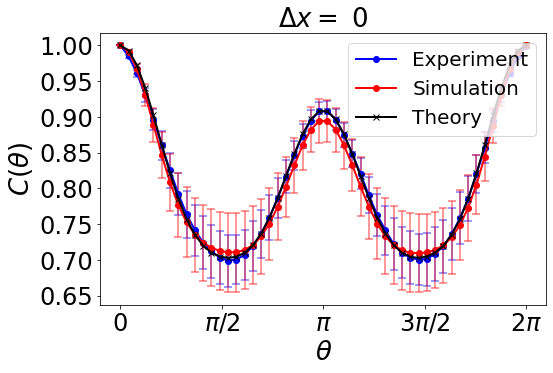

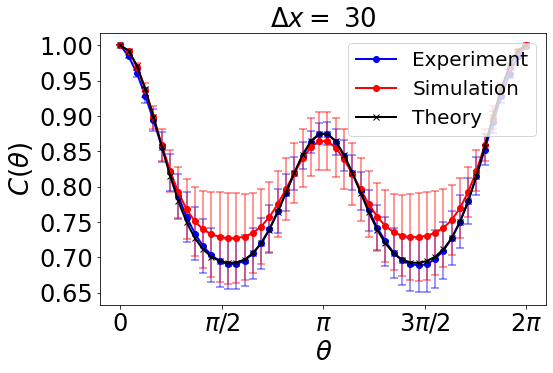

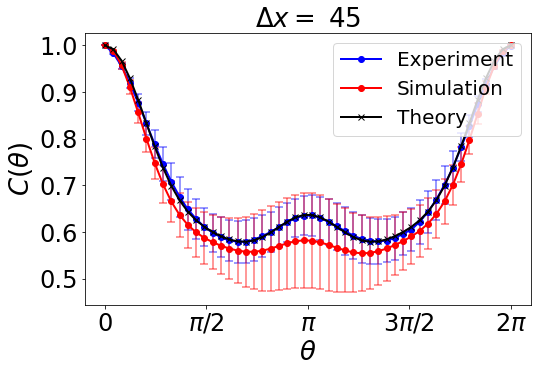

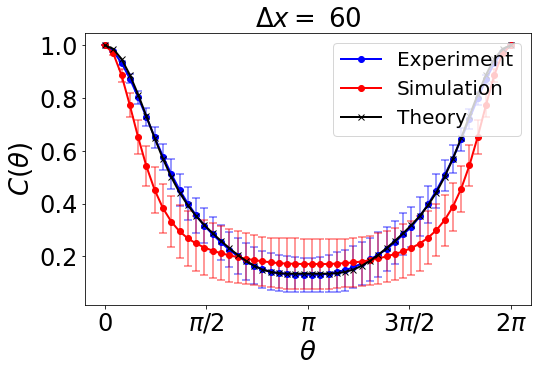

In [96]:
def show_RME_corr(show_error=True, ind_deformation=0, save_fig=True):
    # deformations2show = [0,2,3,4]
    plt.figure(figsize=FIGSIZE)

    for ind_deformation in [ind_deformation]:
        plt.errorbar(
            angles,
            Corr_mean_exp[ind_deformation],
            label=rf"Experiment",
            color="blue",
            marker="o",
            linewidth=2,
        )
        if show_error:
            plot_error(
                Corr_mean_exp[ind_deformation],
                Corr_std_exp[ind_deformation],
                color="blue",
            )

    plt.errorbar(
        angles,
        Corr_seg_mean[ind_deformation],
        label=rf"Simulation",
        color="red",
        marker="o",
        linewidth=2,
    )

    if show_error:
        plot_error(
            Corr_seg_mean[ind_deformation], Corr_seg_std[ind_deformation], color="red"
        )

    plt.errorbar(
        angles,
        Corr_theory[ind_deformation],
        label=rf"Theory",
        color="black",
        marker="x",
        linewidth=2,
    )

    plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
    plt.ylabel(r"$C(\theta)$", fontsize=LABEL_SIZE)
    xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
    xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
    plt.xticks(xticks, xtics_labels, fontsize=TICK_SIZE)
    # plt.ylim([0.3, 1.05])
    plt.yticks(fontsize=TICK_SIZE)
    plt.legend(fontsize=LEGEND_SIZE, loc="upper right")
    plt.title(rf"$\Delta x =$ {Delta_x[ind_deformation]:.0f}", fontsize=TITLE_SIZE)

    if save_fig:
        plt.savefig(
            image_path(f"RME_exp_Vs_simu_Dx_{Delta_x[ind_deformation]:.0f}.svg"),
            dpi=300,
        )


for ind_deformation in range(len(deformation_indices)):
    show_RME_corr(show_error=True, ind_deformation=ind_deformation, save_fig=True)

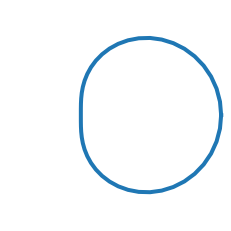

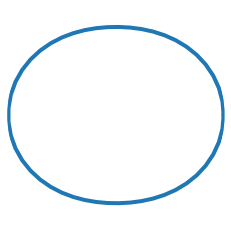

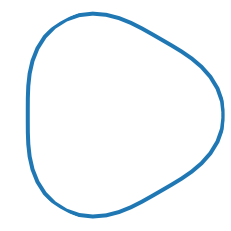

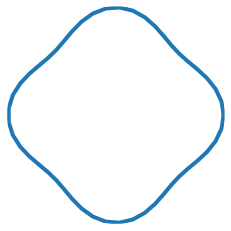

In [91]:
import numpy as np
import matplotlib.pyplot as plt

qs = (1, 2, 3, 4)

# Generate angle values
theta = np.linspace(0, 2 * np.pi, 50)

a = 1

for ind_q, q in enumerate(qs):
    b = 0.1 if q > 1 else 0.5  # Semi-minor axis
    plt.figure()
    # Create polar plot
    radius = a + b * np.cos(q * theta)
    plt.polar(theta, radius, linewidth=4)

    # Remove axis and ticks
    plt.axis("off")

    # Save figure
    if SAVE_FIG:
        plt.savefig(image_path(f"deform_q_{ind_q}.svg"), dpi=300, bbox_inches="tight")